# Titanic 3: Creating a Pipeline and tuning the model with Grid Search Cross Validation

## 1. Data reading and preprocessing

We will first review everything we did in the previous notebook.

In [15]:
import pandas as pd

data = pd.read_csv("housing-classification-iter-0-2.csv") #reading data from csv

### 1.1. Setting X and y

- **X**: columns that help us make a prediction.
- **y**: the column that we want to predict.

In [16]:
X = data
y = X.pop("Expensive")

### 1.2. Feature Selection: keeping only numerical features

Scikit-Learn models cannot deal with categorical features

In [17]:
X_num = X.select_dtypes(include="number")
X.shape

(1460, 9)

### 1.3. Data splitting

In [18]:
from sklearn.model_selection import train_test_split

X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, 
                                                            y, 
                                                            test_size=0.2, 
                                                            random_state=31416)

### 1.4. Imputing missing values

(Fit on train, transform train & test)

In [19]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer() # initialize
my_imputer.fit(X_num_train) # fit on the train set
X_num_imputed_train = my_imputer.transform(X_num_train) # transform the train set
X_num_imputed_test = my_imputer.transform(X_num_test) # transform the test set

### 1.5. Modelling: Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [39]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier 

# 2. initialize the model
my_tree = DecisionTreeClassifier(max_depth=5,
                                 min_samples_leaf=12
                                )

# 3. fit the model to the train data
my_tree.fit(X = X_num_imputed_train, 
            y = y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=12)

### 1.6. Check accuracy on the train set

In [43]:
from sklearn.metrics import accuracy_score

y_pred_tree_train = my_tree.predict(X_num_imputed_train)

train_accuracy= accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train)

round(train_accuracy, 3)

0.931

### 1.7. Check accuracy on the test set

In [42]:
y_pred_tree_test = my_tree.predict(X_num_imputed_test)

test_accuracy= accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test)

round(test_accuracy, 3)

0.932

## 2. Creating a Pipeline

Before moving forward in our quest to improve the model, take a moment to learn how to use Scikit-Learn Pipelines. They will not increase your performance, but they are a necessary tool to compress all the steps in the data preparation + modelling phases into a single one, and this will become very relevant as we move forward and keep adding new steps:

* Read the lesson "Scikit-Learn Pipelines" on the platform.

* Check the docs: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

# 1. initialize transformers &amp; model
imputer = SimpleImputer(strategy="median")
dtree = DecisionTreeClassifier(max_depth=5,
                               min_samples_leaf=12)
 
# 2. Create a pipeline*
pipe = make_pipeline(imputer, dtree)
 
# 3. Fit the pipeline to the training data
pipe.fit(X_num_train, y_train)
 
# 4. Use the pipeline to make predictions
pipe.predict(X_num_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

Now, the object `pipie` can take (almost) raw data as input and output predictions. We no longer need to impute missing values and use the model to make predictions in separate steps.

## 3. Using GridsearchCV to find the best parameters

So far, we tuned the hyperparameters of the decision tree manually. This is not ideal, for two reasons:

- It's not efficient in terms of quickly finding the best combination of parameters.
- If we keep checking the performance on the test set over and over again, we might end up creating a model that fits that particular test set, but does not generalize as well with new data. Test sets are meant to reamain unseen until the very last moment of ML development —we have been cheating a bit!

Grid Search Cross Validation solves both issues:

* Read the lesson "Housing Prices: Iteration 2, Grid Search & Cross Validation" on the platform.

* Check the docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [25]:
# 1. initialize transformers &amp; model
imputer = SimpleImputer()
dtree = DecisionTreeClassifier()
 
# 2. Create a pipeline*
pipe = make_pipeline(imputer, dtree)

param_grid = {
    'decisiontreeclassifier__max_depth': range(2, 12),
    'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(3, 40, 5),
    'decisiontreeclassifier__criterion':['gini', 'entropy']
    }
    
from sklearn.model_selection import GridSearchCV
 
search = GridSearchCV(pipe, # you have defined this beforehand
                      param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='accuracy', # the performance metric to use, 
                      verbose=1) # we want informative outputs during the training process

In [26]:
search.fit(X_num_imputed_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 12),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
                         'decisiontreeclassifier__min_samples_split': range(3, 40, 5)},
             scoring='accuracy', verbose=1)

In [45]:
search.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 38}

In [46]:
search.best_score_

0.9280950808847805

In [69]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier 

# 2. initialize the model
my_tree = DecisionTreeClassifier(max_depth=5,
                                 min_samples_leaf=5
                                )

# 3. fit the model to the train data
my_tree.fit(X = X_num_imputed_train, 
            y = y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [70]:
from sklearn.metrics import accuracy_score

y_pred_tree_train = my_tree.predict(X_num_imputed_train)

train_accuracy= accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train)

round(train_accuracy,2)

0.94

In [71]:
from sklearn.metrics import accuracy_score

y_pred_tree_test = my_tree.predict(X_num_imputed_test)

test_accuracy= accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test)

round(test_accuracy,2)

0.93

## confusion_matrix

In [54]:
#sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None,sample_weight=None, normalize=None)
from sklearn.metrics import confusion_matrix

confusion_matrix= confusion_matrix(y_test, y_pred_tree_test, labels=None, sample_weight=None, normalize=None)
confusion_matrix

array([[247,   7],
       [ 17,  21]], dtype=int64)

In [55]:
#sklearn.metrics.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source]¶

In [56]:
from sklearn.metrics import classification_report

classification_report(y_test, y_pred_tree_test,labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n           0       0.94      0.97      0.95       254\n           1       0.75      0.55      0.64        38\n\n    accuracy                           0.92       292\n   macro avg       0.84      0.76      0.80       292\nweighted avg       0.91      0.92      0.91       292\n'

In [57]:
print(classification_report(y_test, y_pred_tree_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       254
           1       0.75      0.55      0.64        38

    accuracy                           0.92       292
   macro avg       0.84      0.76      0.80       292
weighted avg       0.91      0.92      0.91       292



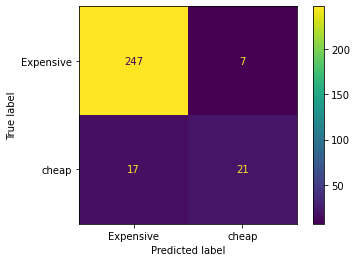

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

display= ConfusionMatrixDisplay(confusion_matrix,display_labels=['Expensive','cheap'])
display.plot()
plt.show()

In [68]:
from sklearn.metrics import cohen_kappa_score

#cohen_kappa_score('y_test', 'y_pred_tree_test', labels=None, weights=None, sample_weight=None)
